All the code names are:
	[CS CM CC][Len SSize MFit CAtom][G3]
	[CS CM CC][SSize MFit CAtom][G3]
	[CS CM CC][Len MFit CAtom][G3]
	[CS CM CC][Len SSize CAtom][G3]
	[CS CM CC][Len SSize MFit][G3]
	[OS CM CC][Len SSize MFit CAtom][G3]
	[CS OM CC][Len SSize MFit CAtom][G3]
	[CS CM OC][Len SSize MFit CAtom][G3]
	[CS CM CC][Len SSize MFit CAtom][Gauto]
	[CS CM CC][Len SSize MFit CAtom][G4]
	[CS CM CC][Len SSize MFit CAtom][G5]

Code name: [CS CM CC][Len SSize MFit CAtom][G3]
Excluded results due to missing fields: 0


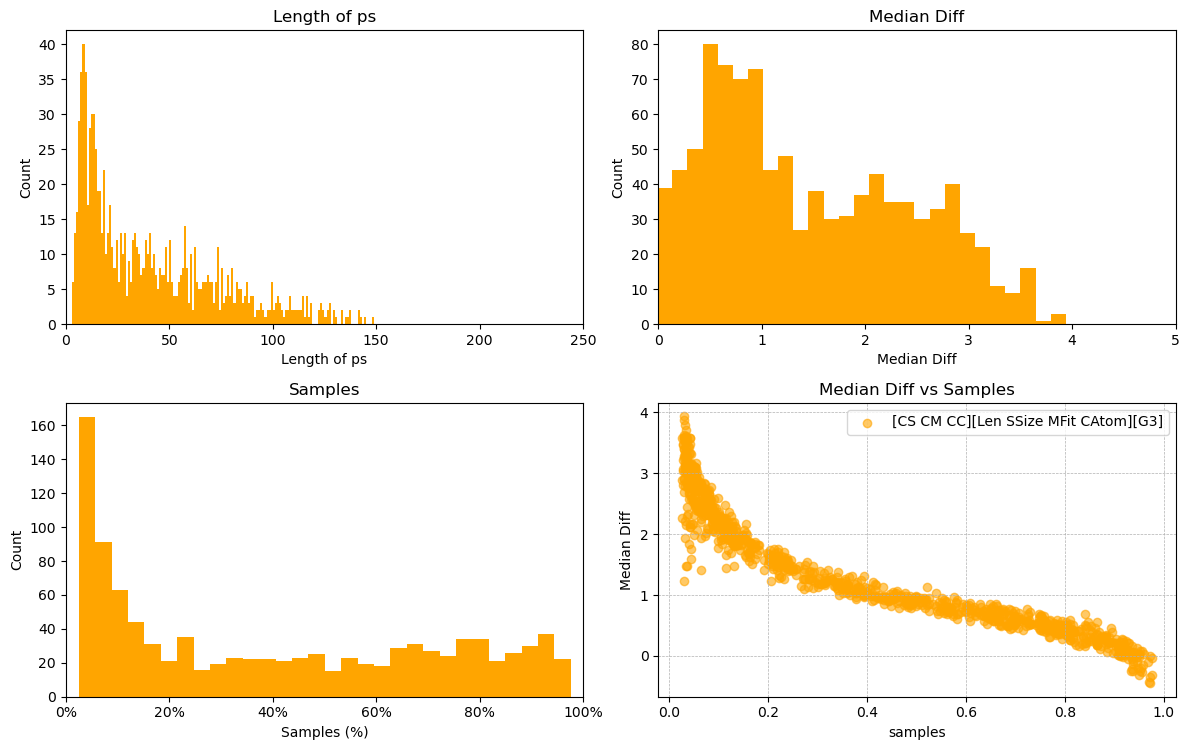


Code name: [CS CM CC][SSize MFit CAtom][G3]
Excluded results due to missing fields: 0


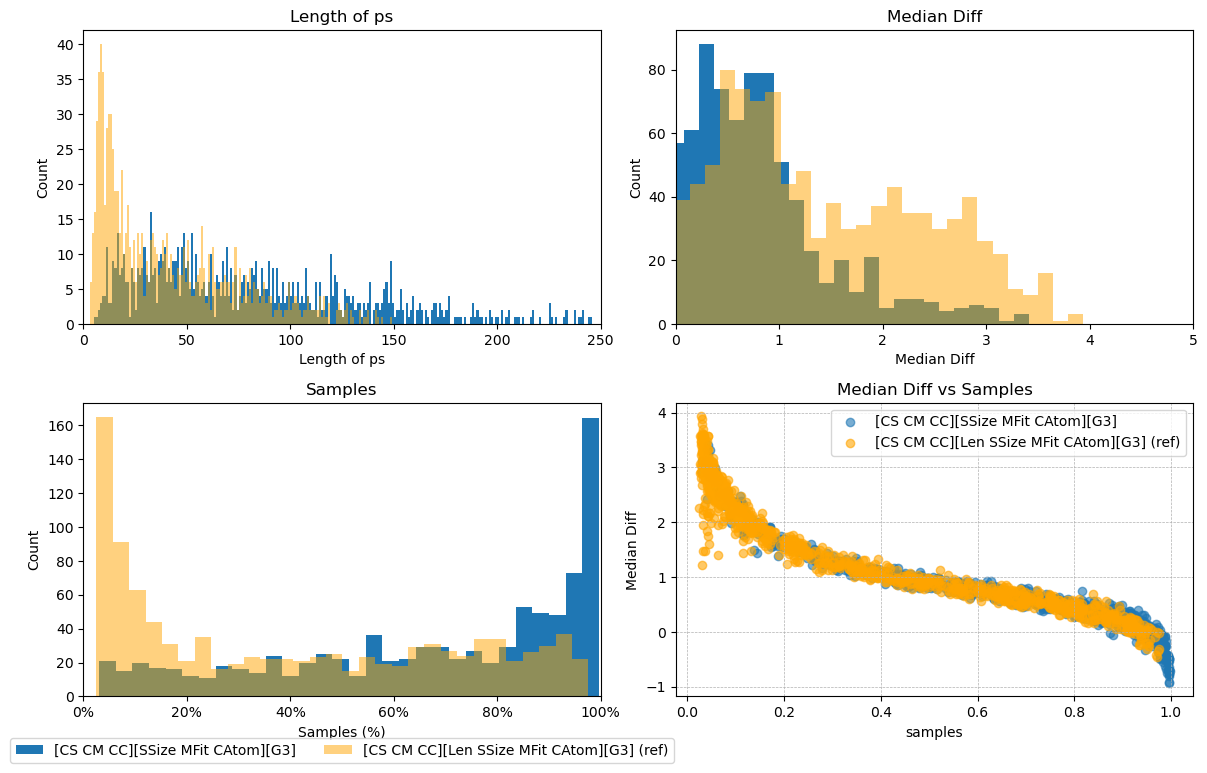


Code name: [CS CM CC][Len MFit CAtom][G3]
Excluded results due to missing fields: 0


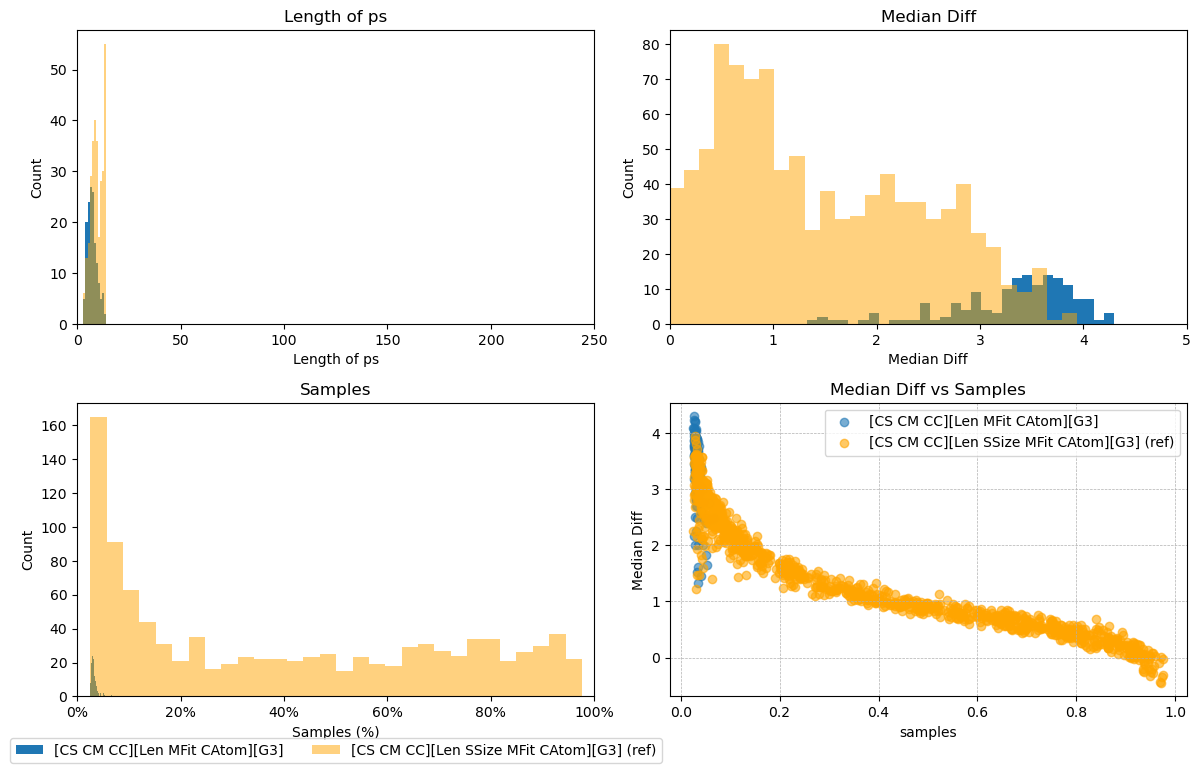


Code name: [CS CM CC][Len SSize CAtom][G3]
Excluded results due to missing fields: 0


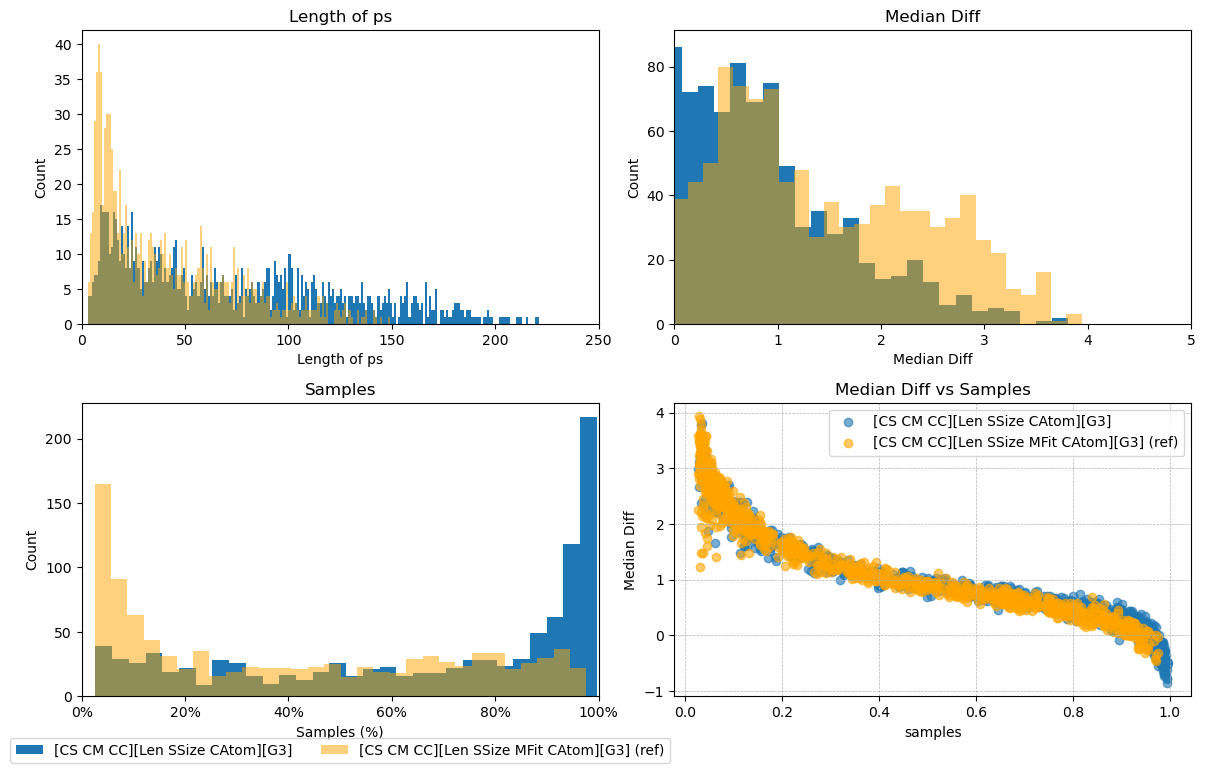


Code name: [CS CM CC][Len SSize MFit][G3]
Excluded results due to missing fields: 0


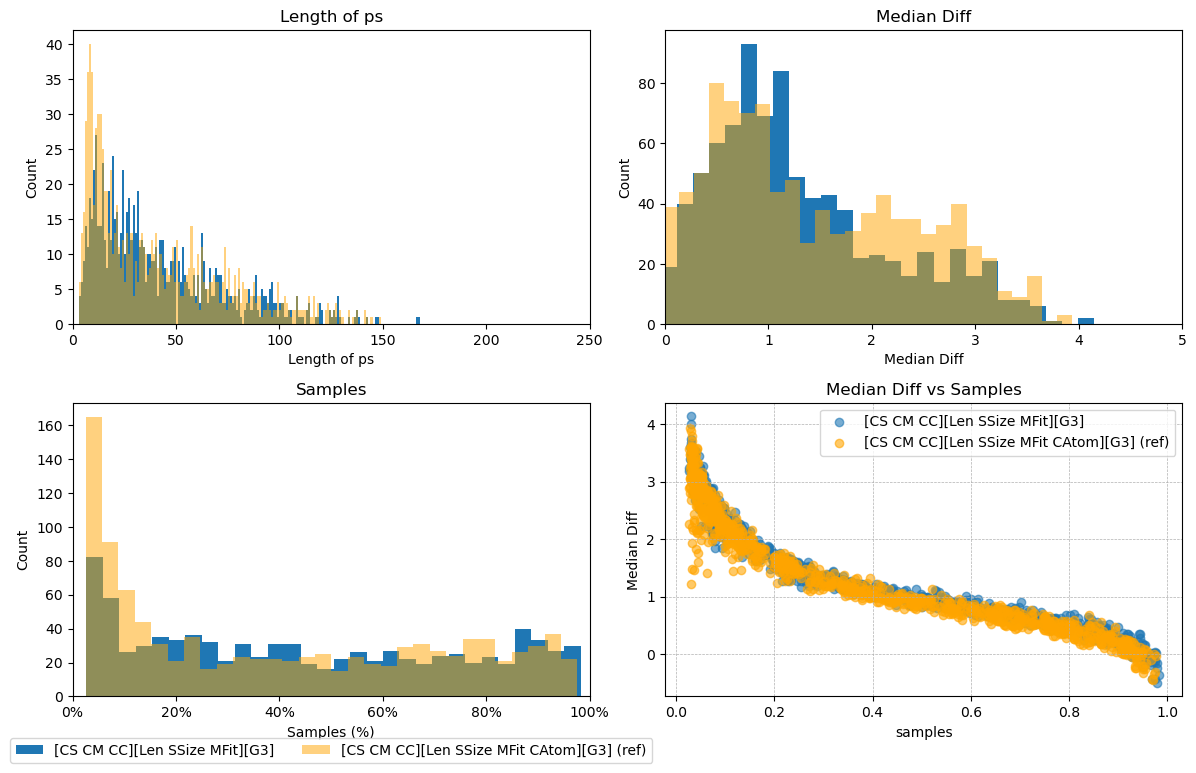


Code name: [OS CM CC][Len SSize MFit CAtom][G3]
Excluded results due to missing fields: 0


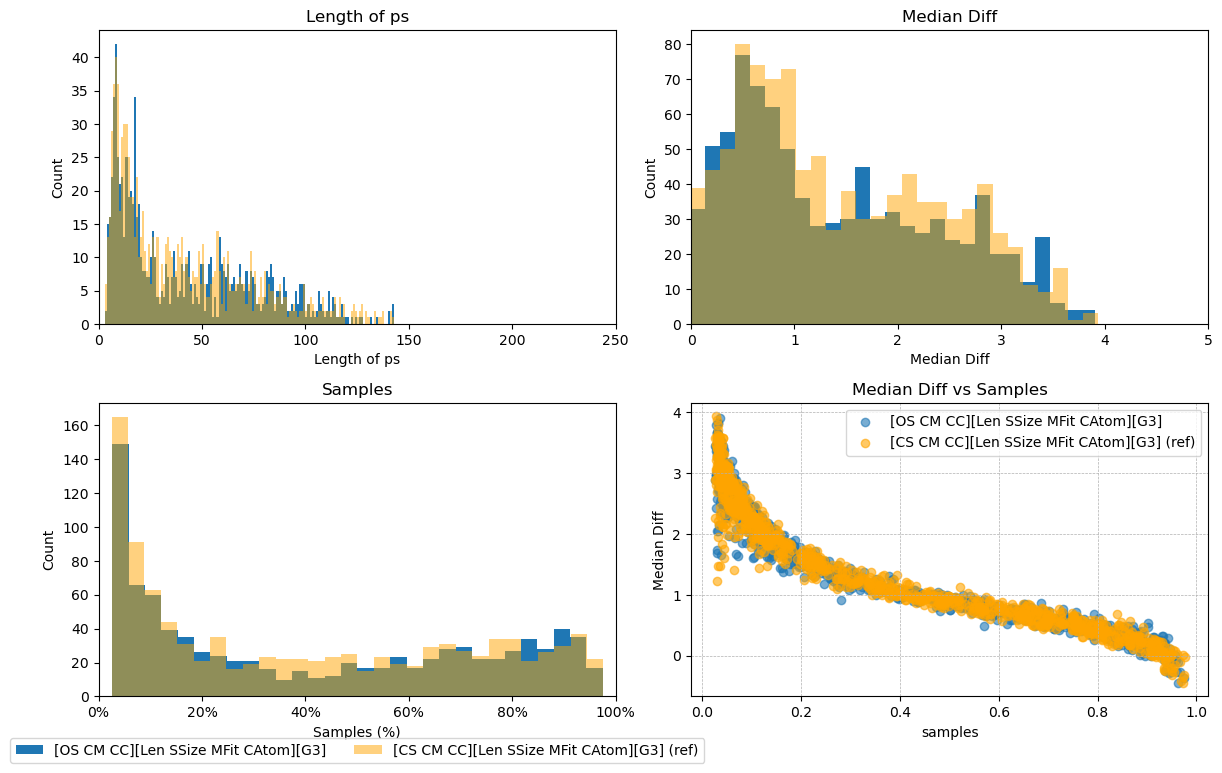


Code name: [CS OM CC][Len SSize MFit CAtom][G3]
Excluded results due to missing fields: 0


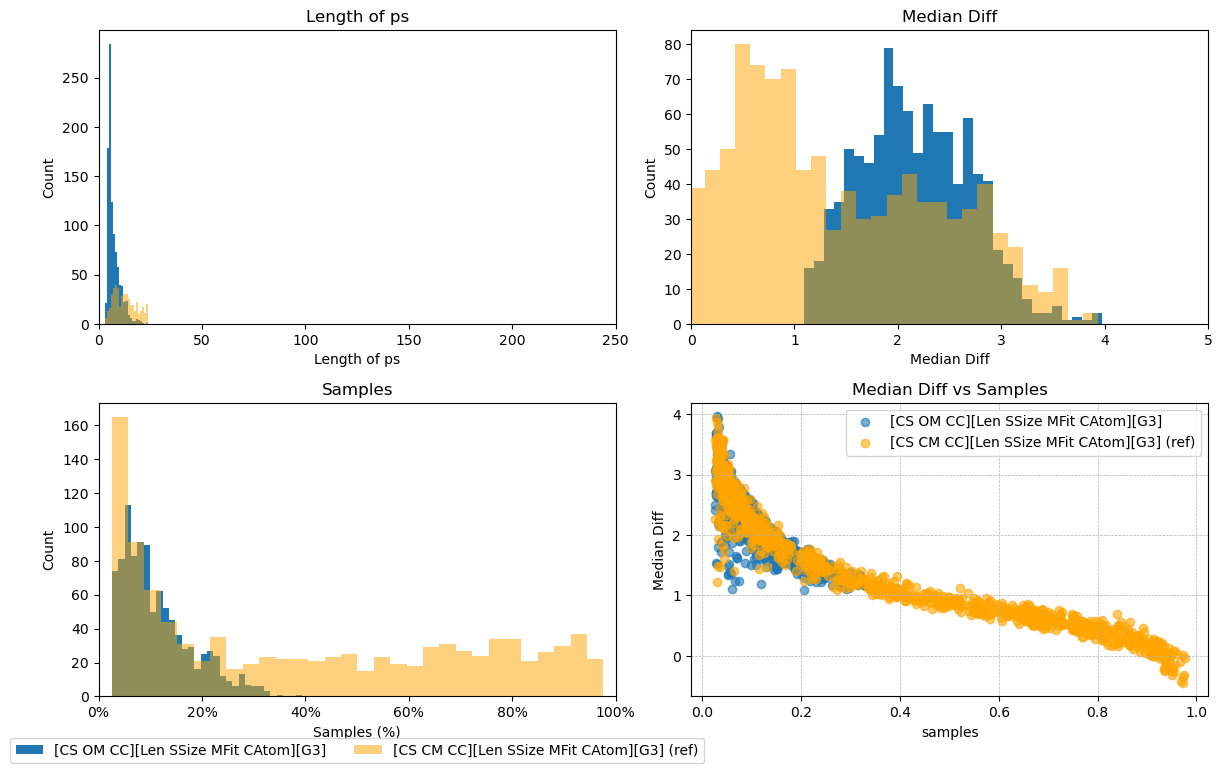


Code name: [CS CM OC][Len SSize MFit CAtom][G3]
Excluded results due to missing fields: 0


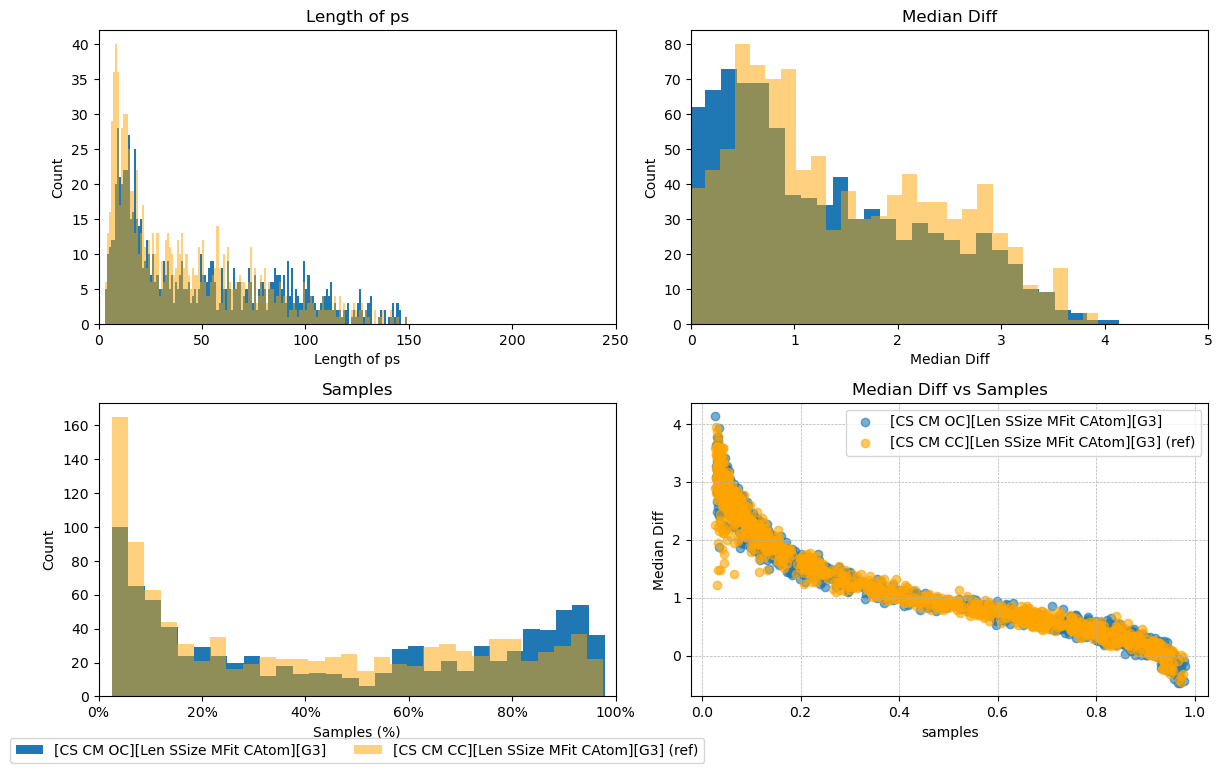


Code name: [CS CM CC][Len SSize MFit CAtom][Gauto]
Excluded results due to missing fields: 1


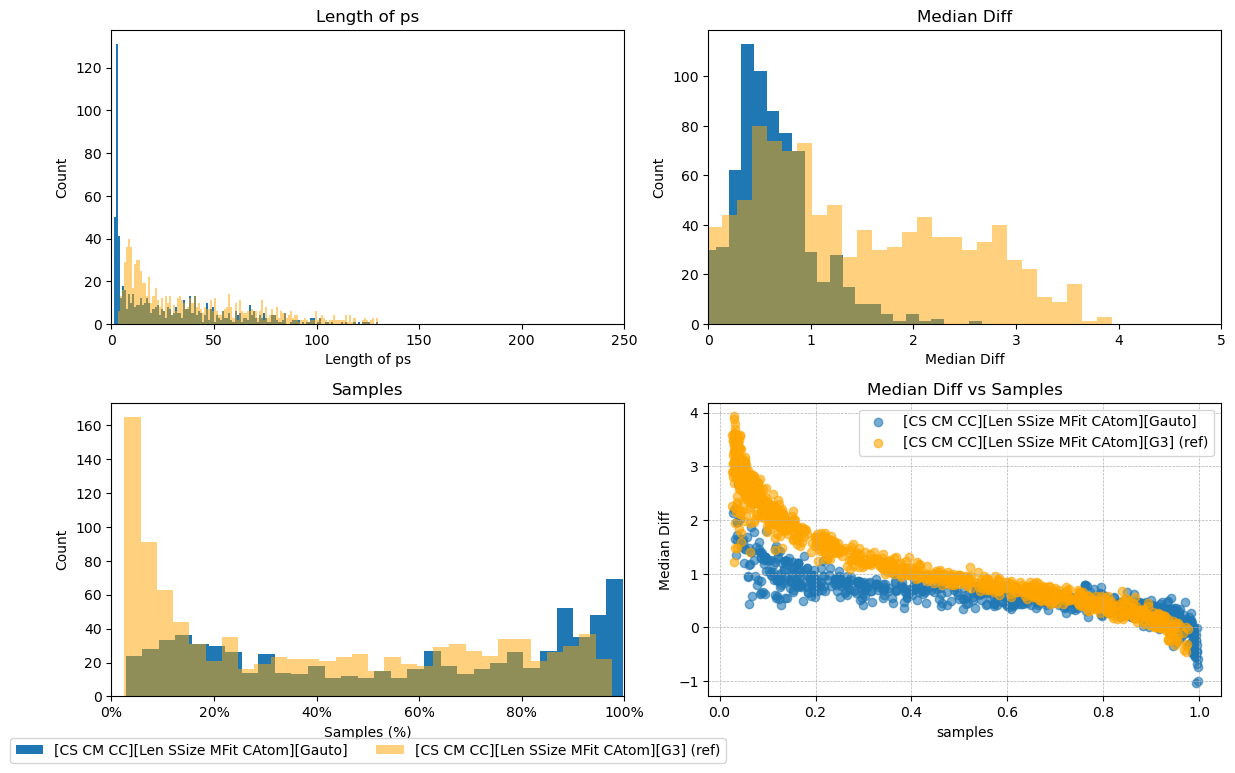


Code name: [CS CM CC][Len SSize MFit CAtom][G4]
Excluded results due to missing fields: 0


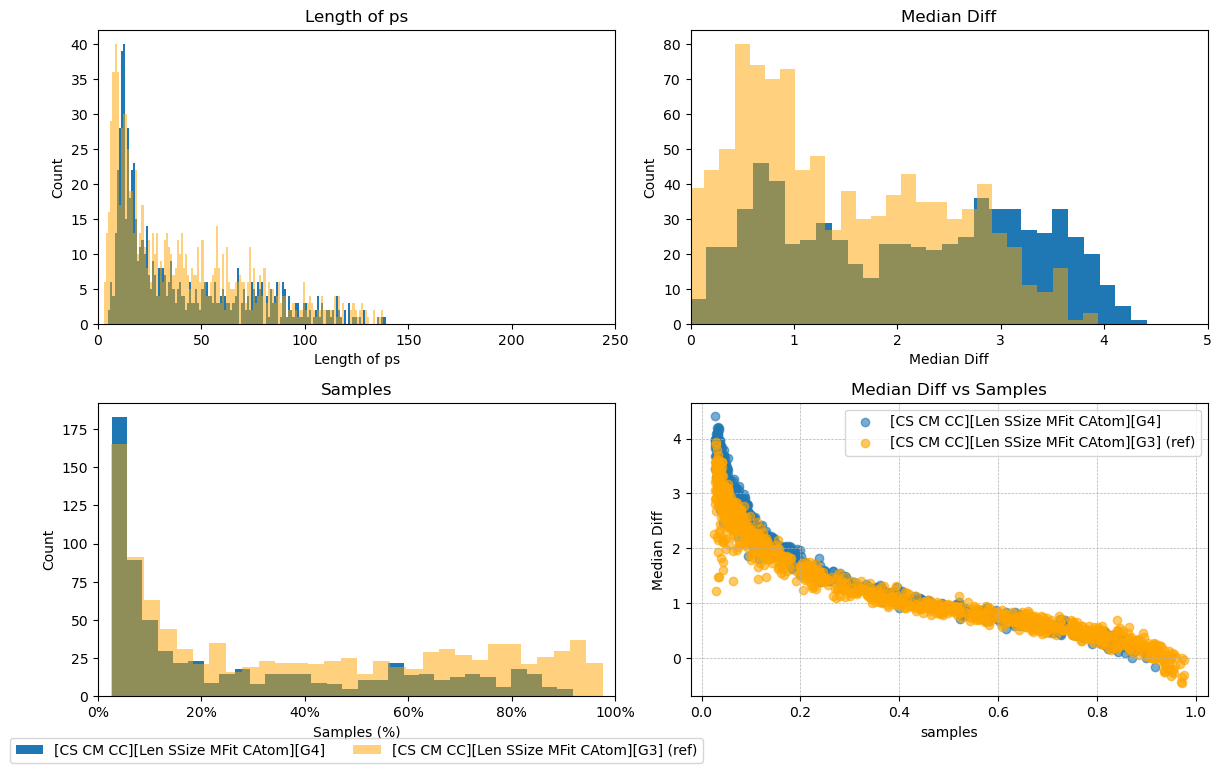


Code name: [CS CM CC][Len SSize MFit CAtom][G5]
Excluded results due to missing fields: 0


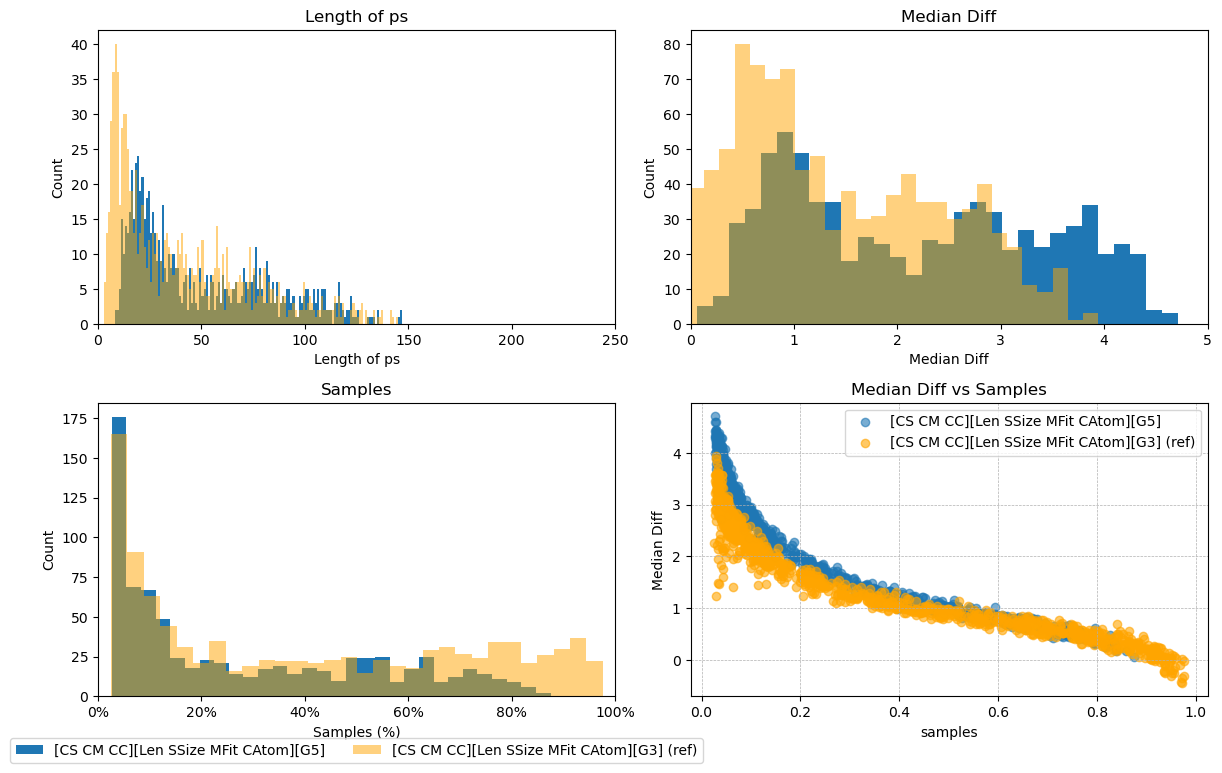

In [43]:
from Gian_experimental.NSGAIICustom.evolving_genome_threshold import NCSolutionWithGT
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path
import copy
import json
import os
import asyncio
import random

import utils
from Core.PSMetric.Linkage.ValueSpecificMutualInformation import GlobalLinkageBasedOnMutualInformation
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import OptimisedSPref
from PolishSystem.read_data import get_pRef_from_vectors
from initial_testing.data_collection_25_06_9.genome_threshold_search import PolishSearchSettings, \
    search_for_pss_using_genome_threshold, results_to_json

cluster_info_file_name = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\cluster_info_250_random.pkl"
data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
def in_path(path):
    return os.path.join(data_path, path)


# Set the path to your results folder
results_path = Path(r"C:\Users\gac8\PycharmProjects\PSSearch\initial_testing\data_collection_25_06_9\results\v5") 
json_files = list(results_path.glob("*.json"))

# Storage for grouped data by code_name
data_by_code = defaultdict(list)
excluded_counts = defaultdict(int)

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path("train_many_hot_vectors_250_random.csv"),
                                   name_of_fitness_file=in_path("train_fitness_250_random.csv"),
                                   column_in_fitness_file=2)
test_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path("test_many_hot_vectors_250_random.csv"),
                                  name_of_fitness_file=in_path("test_fitness_250_random.csv"),
                                  column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

chosen_SPref = train_SPRef

def get_measurements_for_entry(results):
    pss = [NCSolutionWithGT(set(entry["ps"]), genome_threshold=entry["genome_threshold"])
           for entry in results]
    
    samples = []
    lengths = []
    mean_fitnesses = []
    for ps in pss:
        matches, non_matches = chosen_SPref.partition(ps, ps.genome_threshold)
        samples.append(len(matches))
        lengths.append(len(ps))
        mean_fitnesses.append(np.average(matches) if len(matches) > 0 else -1)
    return {"samples": samples, "lengths": lengths, "mean_fitnesses": mean_fitnesses}
    


# Read and parse JSON files
for file in json_files:
    with open(file, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Failed to decode {file}")
            continue
        for entry in data:
            code_name = entry.get("config", {}).get("code_name", "UNKNOWN")
            
            for result in entry.get("results", []):
                if "median_diff" in result and "p_value" in result:
                    data_by_code[code_name].append(result)
                else:
                    excluded_counts[code_name] += 1
                   
                    
# print all the code names seen
print("All the code names are:")
for code_name, results in data_by_code.items():             
    print("\t" + code_name)

# Plotting
show_len = True
show_md = True
show_p_values = False
show_samples = True
show_scatterplot = True

def map_sample(g):
        return 1-(1/(1+g))


# Track the first code name and its data
first_code_name = next(iter(data_by_code)) 
first_data = data_by_code[first_code_name]
first_ps_lengths = [len(r["ps"]) for r in first_data]
first_median_diffs = [r["median_diff"] for r in first_data]
first_p_values = [r["p_value"] for r in first_data]

if "v4" in results_path.name:
    first_samples = [map_sample(r["samples"]) for r in first_data]
else:
    first_samples = [r["samples"] for r in first_data]

# Plotting
for code_index, (code_name, results) in enumerate(data_by_code.items()):
    print(f"\nCode name: {code_name}")
    print(f"Excluded results due to missing fields: {excluded_counts[code_name]}")
    
    ps_lengths = [len(r["ps"]) for r in results]
    median_diffs = [r["median_diff"] for r in results]
    p_values = [r["p_value"] for r in results]

    if "v4" in results_path.name:
        samples = [map_sample(r["samples"]) for r in results]
    else:
        samples = [r["samples"] for r in results]

    # Histogram plots
    plt.figure(figsize=(12, 8))
    rows = 2
    cols = 2
    current_index = 1
    legend_handles = []
    legend_labels = []

    if show_len:
        plt.subplot(rows, cols, current_index)
        current_index +=1
        plt.hist(ps_lengths, bins=range(1, max(ps_lengths)+2), label=code_name, color="orange" if code_name == first_code_name else None)
        if code_name != first_code_name:
            plt.hist(first_ps_lengths, bins=range(1, max(ps_lengths)+2), color='orange', alpha=0.5, label=f"{first_code_name} (ref)")  # <-- added
        plt.title(f'Length of ps')
        plt.xlim(0, 250)
        plt.xlabel("Length of ps")
        plt.ylabel("Count")
        # plt.legend()

    if show_md:
        plt.subplot(rows, cols, current_index)
        current_index +=1
        plt.hist(median_diffs, bins=30, label=code_name, color="orange" if code_name == first_code_name else None)
        if code_name != first_code_name:
            plt.hist(first_median_diffs, bins=30, color='orange', alpha=0.5, label=f"{first_code_name} (ref)")  # <-- added
        plt.title(f'Median Diff')
        plt.xlabel("Median Diff")
        plt.xlim(0, 5)
        plt.ylabel("Count")
        # plt.legend()

    if show_p_values:
        plt.subplot(rows, cols, current_index)
        current_index +=1
        plt.hist(p_values, bins=30, label=code_name, color="orange" if code_name == first_code_name else None)
        if code_name != first_code_name:
            plt.hist(first_p_values, bins=30, color='orange', alpha=0.5, label=f"{first_code_name} (ref)")  # <-- added
        plt.title(f'P-Values')
        plt.xlabel("P-Value")
        plt.ylabel("Count")
        # plt.legend()

    if show_samples:
        plt.subplot(rows, cols, current_index)
        current_index +=1

        samples_percent = [s * 100 for s in samples]
        first_samples_percent = [s * 100 for s in first_samples]

        plt.hist(samples_percent, bins=30, label=code_name, color="orange" if code_name == first_code_name else None)
        if code_name != first_code_name:
            plt.hist(first_samples_percent, bins=30, color='orange', alpha=0.5, label=f"{first_code_name} (ref)")
        
        plt.title(f'Samples')
        plt.xlabel("Samples (%)")
        plt.xlim(0, 100)
        plt.ylabel("Count")

        # Optional: format ticks to show "%" symbols
        from matplotlib.ticker import FuncFormatter
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}%"))


    # Collect legend handles only once
    if code_name != first_code_name:
        legend_handles, legend_labels = plt.gca().get_legend_handles_labels()

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom
    if legend_handles:
        plt.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    #plt.show()

    # Scatter plot: p_value (log) vs median_diff
    if show_scatterplot:
        plt.subplot(rows, cols, current_index)
        current_index += 1
        
        plt.scatter(samples, median_diffs, alpha=0.6, label=code_name, color="orange" if code_name == first_code_name else None)
        if code_name != first_code_name:
            plt.scatter(first_samples, first_median_diffs, color='orange', alpha=0.6, label=f"{first_code_name} (ref)")  # <-- added
        #xplt.xscale('log')
        plt.title(f'Median Diff vs Samples')
        plt.xlabel("samples")
        plt.ylabel("Median Diff")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
    plt.show()
